In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.spatial.distance import jensenshannon

from preprocess import Preprocessor
from dataset import DatasetLoader, FakeOrRealLabel
from textual_relevance import TextualRelevance

pp = Preprocessor()
ds = DatasetLoader()
df = ds.load_horne2017_fakenewsdata(drop_if_less_than_num_contexts=1).as_pandas()

df['label'] = df['label'].apply(lambda label: 1 if label == FakeOrRealLabel.REAL else 0)

for col in ["content", "ctx1_content", "ctx2_content", "ctx3_content"]:
    df[col] = df[col].apply(pp.preprocess_and_tokenize_opt)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [2]:
df

,id,title,content,published,url,label,ctx1_url,ctx1_title,ctx1_content,ctx2_url,ctx2_title,ctx2_content,ctx3_url,ctx3_title,ctx3_content
0,105_Real,Aziz Ansari Why Trump Makes Me Scared for My F...,"[dont, go, anywhere, near, mosque, ,, told, mo...",NaN,NaN,1,https://www.cnn.com/2016/06/12/us/orlando-nigh...,"Orlando shooting: 49 killed, shooter pledged I...","[orlando, ,, florida, cnn, american, -, born, ...",https://www.nytimes.com/2016/06/13/us/politics...,Donald Trump Seizes on Orlando Shooting and Re...,"[mrs, ., clinton, use, phrase, respond, direct...",https://news.yahoo.com/trump-revives-talk-of-b...,Trump revives talk of banning Muslims after Or...,"[manchester, ,, n, ., h, ., first, formal, rem..."
1,124_Real,I Ran the C.I.A. Now I'm Endorsing Hillary Cli...,"[33, -, year, career, central, intelligence, a...",NaN,NaN,1,https://www.reuters.com/article/us-usa-russia-...,Trump backs Putin on election meddling at summ...,"[helsinki, (, reuters, ), -, standing, side, s...",https://www.nytimes.com/2019/01/14/us/politics...,"Trump Discussed Pulling U.S. From NATO, Aides ...","[washington, thing, president, vladimir, v, .,...",https://www.cnn.com/2018/07/16/politics/donald...,Helsinki summit: Trump sides with Putin over U...,"[helsinki, ,, finland, cnn, us, president, don..."
2,151_Real,Why Donald Trump Should Not Be President\n,"[donald, trump, began, improbable, run, presid...",NaN,NaN,1,https://www.nytimes.com/2016/11/09/us/politics...,Donald Trump Is Elected President in Stunning ...,"[that, ,, added, ,, important, me, ., offered,...",https://www.newyorker.com/magazine/2018/10/01/...,How Russia Helped Swing the Election for Trump,"[wikileaks, release, wa, russian, -, backed, e...",https://www.bbc.com/news/election-us-2016-3782...,US election 2016: What really happened with th...,"["", since, 2010, ,, foundation, ha, worked, gr..."
3,140_Real,The rise of Donald Trump is a terrifying momen...,"[monday, ,, donald, trump, held, rally, manche...",NaN,NaN,1,https://www.vox.com/2016/2/10/10956978/donald-...,The rise of Donald Trump is a terrifying momen...,"[monday, ,, donald, trump, held, rally, manche...",https://www.fosters.com/story/opinion/columns/...,It's a shame to lose friends over politics,"[alicia, preston, almost, over, !, negative, m...",https://www.cnn.com/2019/08/16/politics/donald...,"Donald Trump bullied a man as overweight, then...","[cnn, 2020, campaign, rally, new, hampshire, t..."
4,138_Real,The real Clinton email scandal is that a bulls...,"[time, ago, ,, hillary, clinton, adviser, deci...",NaN,NaN,1,https://www.nytimes.com/2015/03/03/us/politics...,Hillary Clinton Used Personal Email Account at...,"[washington, hillary, rodham, clinton, exclusi...",https://www.politico.com/magazine/story/2016/0...,What the FBI Files Reveal About Hillary Clinto...,"[scandal, hillary, clintons, home, brew, email...",https://www.bbc.com/news/world-us-canada-31806907,Hillary Clinton emails - what's it all about?,"[hillary, clinton, email, -, what, ', s, about..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,23_Fake,ISIS LEADER CALLS FOR AMERICAN MUSLIM VOTERS T...,"[top, isis, leader, believed, number, two, beh...",NaN,NaN,0,https://www.snopes.com/fact-check/isis-leader-...,ISIS Leader Calls for American Muslim Voters t...,"[11, october, 2016, ,, web, site, world, news,...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
93,40_Fake,Sauron Endorses Donald Trump for President\n,"[trump, refuse, disavow, dark, lords, support,...",NaN,NaN,0,https://foreignpolicy.com/2019/10/21/trump-adm...,Why Mordor Failed,"[administration, u, ., s, ., president, donald...",https://www.theatlantic.com/ideas/archive/2018...,The Saruman Trap,"[conservatives, distress, turn, ancient, texts...",https://bluevirginia.us/2016/03/bernie-not-gan...,Bernie is NOT Gandalf; Hillary is NOT Saruman;...,"[read, gandalf, ., need, unite, behind, saruma..."
94,14_Fake,"""Donald Trump Protester Speaks Out """"I Was Pai...","[phoenix, a, ., z, ., (, ap, ), month

In [3]:
tfidf_1_1 = TextualRelevance('tfidf', df.content, ngram_range=(1, 1))
tfidf_1_2 = TextualRelevance('tfidf', df.content, ngram_range=(1, 2))
word2vec = TextualRelevance('word2vec')

tf_idf_1_1_cosine_dist = []
tf_idf_1_1_word_app = []
tf_idf_1_1_matching = []

tf_idf_1_2_cosine_dist = []
tf_idf_1_2_word_app = []
tf_idf_1_2_matching = []

word2vec_cosine_dist = []

for i in range(len(df)):
    contents = []
    for context in [df['ctx1_content'].iloc[i], df['ctx2_content'].iloc[i], df['ctx3_content'].iloc[i]]:
        if isinstance(context, list):
            contents.append(context)

    tf_idf_1_1_cosine_dist.append(tfidf_1_1.cosine_dist(df['content'].iloc[i], contents))
    tf_idf_1_1_word_app.append(tfidf_1_1.word_appearance(df['content'].iloc[i], contents))
    tf_idf_1_1_matching.append(tfidf_1_1.matching_score(df['content'].iloc[i], contents))

    tf_idf_1_2_cosine_dist.append(tfidf_1_2.cosine_dist(df['content'].iloc[i], contents))
    tf_idf_1_2_word_app.append(tfidf_1_2.word_appearance(df['content'].iloc[i], contents))
    tf_idf_1_2_matching.append(tfidf_1_2.matching_score(df['content'].iloc[i], contents))

    
    word2vec_cosine_dist.append(word2vec.cosine_dist(df['content'].iloc[i], contents))

df['tf_idf_1_1_cosine_dist'] = tf_idf_1_1_cosine_dist
df['tf_idf_1_1_word_app'] = tf_idf_1_1_word_app
df['tf_idf_1_1_matching'] = tf_idf_1_1_matching

df['tf_idf_1_2_cosine_dist'] = tf_idf_1_2_cosine_dist
df['tf_idf_1_2_word_app'] = tf_idf_1_2_word_app
df['tf_idf_1_2_matching'] = tf_idf_1_2_matching

df['word2vec_cosine_dist'] = word2vec_cosine_dist

df['tf_idf_1_1_harmonic_mean'] = 3 * np.multiply(np.multiply(tf_idf_1_1_cosine_dist, tf_idf_1_1_word_app), tf_idf_1_1_matching) / (np.array(tf_idf_1_1_cosine_dist) + np.array(tf_idf_1_1_word_app) + np.array(tf_idf_1_1_matching))
df['tf_idf_1_2_harmonic_mean'] = 3 * np.multiply(np.multiply(tf_idf_1_2_cosine_dist, tf_idf_1_2_word_app), tf_idf_1_2_matching) / (np.array(tf_idf_1_2_cosine_dist) + np.array(tf_idf_1_2_word_app) + np.array(tf_idf_1_2_matching))

/home/duke/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
updated_df = df[['id', 'title', 'label', 'word2vec_cosine_dist', 'tf_idf_1_1_cosine_dist', 'tf_idf_1_1_word_app', 'tf_idf_1_1_matching', 'tf_idf_1_2_cosine_dist', 'tf_idf_1_2_word_app', 'tf_idf_1_2_matching', 'tf_idf_1_1_harmonic_mean', 'tf_idf_1_2_harmonic_mean']]

Comparison between
- Cosine Distance: Word2Vec, TF-IDF(1-1), TF-IDF(1-2)
- Word App: TF-IDF(1-1), TF-IDF(1-2)
- Matching Score: TF-IDF(1-1), TF-IDF(1-2)
- Harmonic Mean of Three Metrics: TF-IDF(1-1), TF-IDF(1-2)

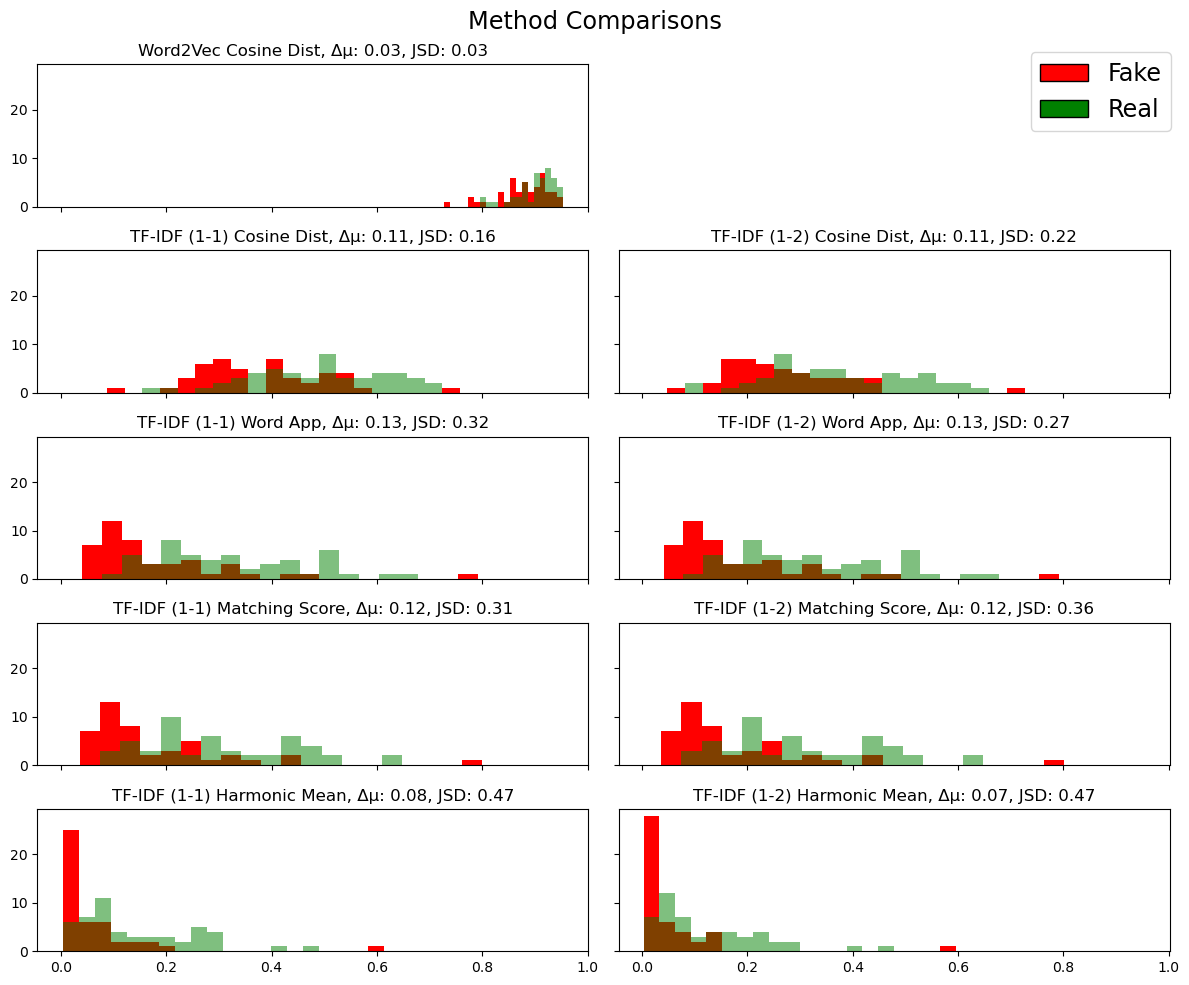

In [72]:
def jsd(p, q, base=np.e):
    '''Jenson-Shanon Distance
    Reference: https://stackoverflow.com/questions/20302636/js-divergence-between-two-discrete-probability-distributions-of-unequal-length
    '''
    if len(p) > len(q):
        p = np.random.choice(p, len(q)) # random.choice make same length to p/q
    elif len(q) > len(p):
        q = np.random.choice(q, len(p))
    p, q = np.asarray(p), np.asarray(q)
    
    return jensenshannon(p, q)

colors = ["red", "green"]
labels = ["Fake", "Real"]

def plot_given_method(ax_, df, method, method_name):
    _, bins, _ = ax_.hist(df[df.label == 0][method], bins=20, color = colors[0])
    _ = ax_.hist(df[df.label == 1][method], bins=bins, alpha = 0.5, color = colors[1])
    
    # Use Jensen-Shannon Distance
    dist = jsd(df[df.label == 0][method], df[df.label == 1][method])
    delta_mu = abs(df[df.label == 0][method].mean() - df[df.label == 1][method].mean())

    ax_.set_title(f"{method_name}, Δµ: {delta_mu:.2f}, JSD: {dist:.2f}")

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(12, 10), sharex=True, sharey=True)
ax = axes.ravel()
ax[1].set_visible(False)

plot_given_method(ax[0], updated_df, 'word2vec_cosine_dist', 'Word2Vec Cosine Dist')
plot_given_method(ax[2], updated_df, 'tf_idf_1_1_cosine_dist', 'TF-IDF (1-1) Cosine Dist')
plot_given_method(ax[3], updated_df, 'tf_idf_1_2_cosine_dist', 'TF-IDF (1-2) Cosine Dist')
plot_given_method(ax[4], updated_df, 'tf_idf_1_1_word_app', 'TF-IDF (1-1) Word App')
plot_given_method(ax[5], updated_df, 'tf_idf_1_2_word_app', 'TF-IDF (1-2) Word App')
plot_given_method(ax[6], updated_df, 'tf_idf_1_1_matching', 'TF-IDF (1-1) Matching Score')
plot_given_method(ax[7], updated_df, 'tf_idf_1_2_matching', 'TF-IDF (1-2) Matching Score')
plot_given_method(ax[8], updated_df, 'tf_idf_1_1_harmonic_mean', 'TF-IDF (1-1) Harmonic Mean')
plot_given_method(ax[9], updated_df, 'tf_idf_1_2_harmonic_mean', 'TF-IDF (1-2) Harmonic Mean')

handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.49, 0.45, 0.5, 0.5), fontsize='xx-large')

fig.suptitle('Method Comparisons', fontsize='xx-large')
fig.tight_layout()

## Export CSV

In [73]:
updated_df.to_csv('fakeNewsDataset.csv')